In [1]:
import toml
import random
import matplotlib.pyplot as plt
from toolz import keyfilter, dissoc
from aging.size_norm.data import AugmentationParams, TrainingPaths, Augmenter, SizeNormDataset, CurriculumPipeline
from aging.plotting import figure, save_factory, format_plots, PlotConfig
import lightning.pytorch as pl

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "fig-s1", tight_layout=False)

In [3]:
def keep(d, keys):
    return keyfilter(lambda k: k in keys, d)

In [4]:
config = toml.load(
    # "/n/groups/datta/win/longtogeny/size_norm/models/bottleneck_optimization_00/stage_06/8a4a38f8-6d43-4df4-988e-8d17402bb23c/config.toml"  # version 11
    "/n/groups/datta/win/longtogeny/size_norm/models/freeze_decoder_00/stage_09/7b96ec7e-f894-4391-8c39-f0cb8d7dd516/config.toml"  # version 12
)


paths = keep(
    config["paths"], ["training", "wall_noise", "validation", "age_validation"]
)
training_paths = TrainingPaths(**paths)
config["augmentation"]["rng"] = random.Random(1)
augmentation = AugmentationParams(**dissoc(config["augmentation"], "seed"))

augment = CurriculumPipeline(
    1e-4,
    augmentation,
    [1, 1, 1],
)

In [5]:
dataset = SizeNormDataset(training_paths)

In [6]:
x, y = dataset[0]

In [7]:
pl.seed_everything(1)

[rank: 0] Seed set to 1


1

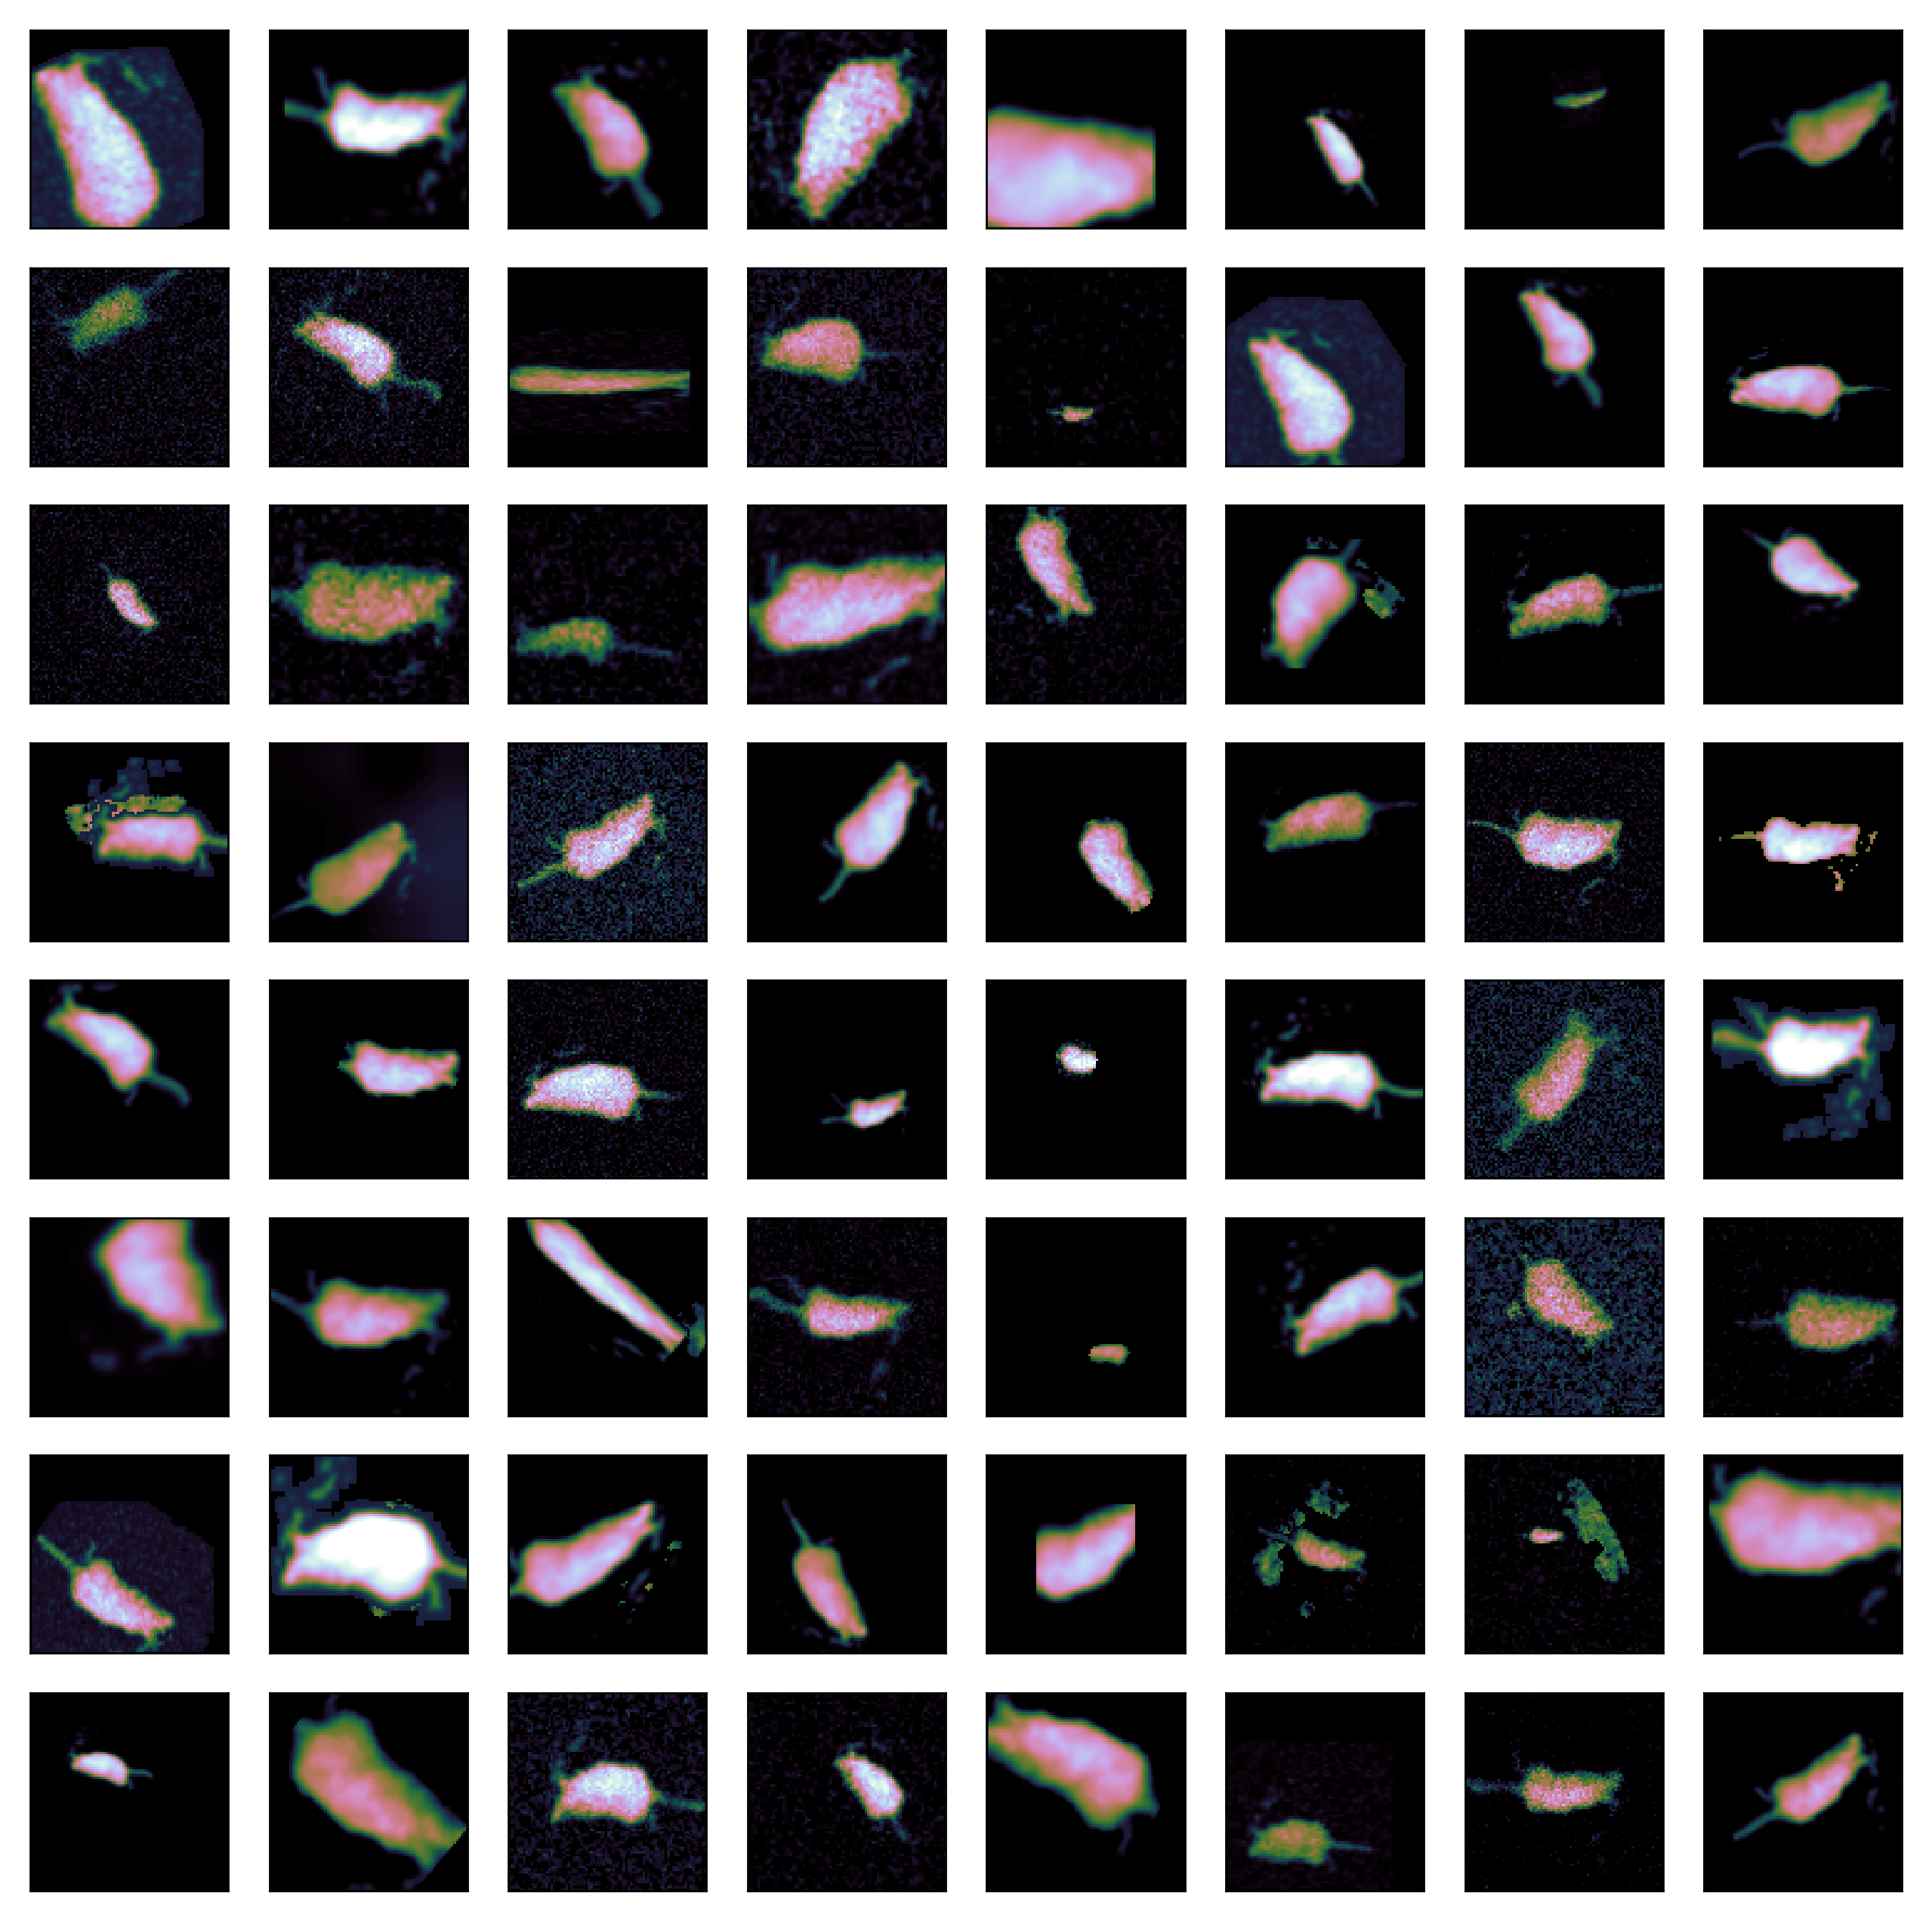

In [8]:
n_rows = 8
fig, ax = plt.subplots(n_rows, n_rows, figsize=(n_rows, ) * 2)
for a in ax.flat:
    new_x = augment(x.unsqueeze(0), -1).squeeze()
    im = a.imshow(new_x * 100, cmap='cubehelix', vmax=45)
    a.set(xticks=[], yticks=[])
saver(fig, 'augmentation-examples');

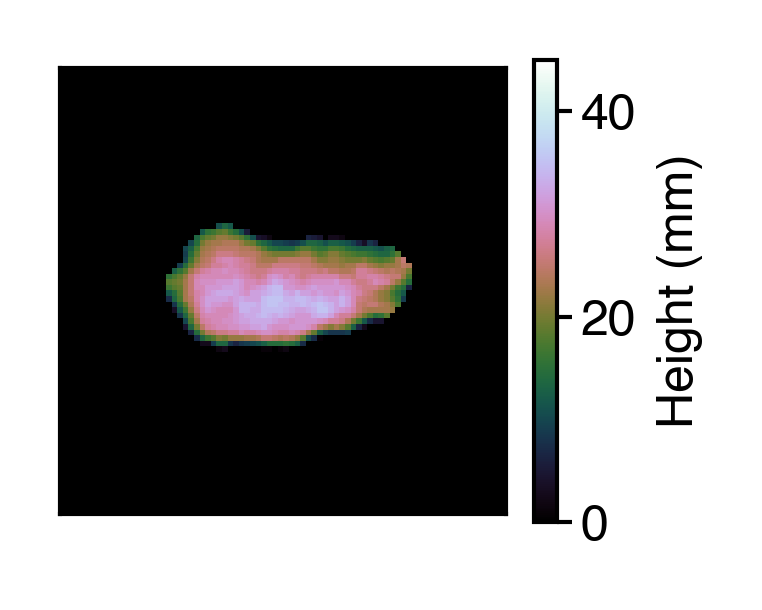

In [9]:
fig = figure(1.2, 1)
ax = fig.gca()
im = ax.imshow(y[0] * 100, cmap="cubehelix", vmax=45)
ax.set(xticks=[], yticks=[])
fig.colorbar(im, ax=ax, label="Height (mm)")
saver(fig, 'dnn-target-reconstruction');